# Solvent Box generation of non-standard solvent and non-standard solutes by means of OpenForceField 

Dependencies:
- openbabel 
- openmoltools (a.t.m. packmol.py should be adjusted)
- openforcefield
- mdtraj
- nglview

In [11]:
#Modules to import

from sys import stdout
import time
import requests
from openbabel import openbabel,pybel
from simtk.openmm import app
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from openforcefield.topology import Molecule, Topology
from openforcefield.utils.toolkits import OpenEyeToolkitWrapper
from openforcefield.typing.engines.smirnoff import ForceField
from openmmforcefields.generators import SystemGenerator
from openmmforcefields.generators import SMIRNOFFTemplateGenerator
from openmoltools import packmol
import numpy as np
import nglview
import ipywidgets
import mdtraj as md
import parmed as pmd
import matplotlib.pyplot as plt
import pandas as pd

## Parameterizing all compounds with the openFF forcefield

### Create input files

In [2]:
#Create force field parameter files for small molecule
#Pubchem id for DBU is 81184, alphaCC1 78175, DMSO 679 (dimethylsulfoxide),DMF 6228, benzylalcohol 244 (benzylthiol 7509), butanol 263
#Provide all Pubchem cids for the compounds which should be added
solutes = ["81184","78175","263"]
solvents = ["679"]

#generate sdf files and transform them to pdb using openbabel
obConversion = openbabel.OBConversion()
obConversion.SetInAndOutFormats("sdf", "pdb")
mol = openbabel.OBMol()
# TODO: Can we add residue names, instead of a cumbursome conversion process in which residue names are added

for cid in solutes+solvents:
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/CID/{cid}/record/SDF/?record_type=3d&response_type=save"
    with open(f"CID_{cid}.sdf", "w") as f:
        f.write(requests.get(url).text)
    obConversion.ReadFile(mol, f"CID_{cid}.sdf")
    obConversion.WriteFile(mol, f"CID_{cid}.pdb")



### Forcefield and simulation settings

Due to conflicting packages (openforcefield Forcefield and OpenMM Forcefield), we already define the forcefield here in the case of the openFF.

In [3]:
from openforcefield.utils import *
from openforcefield.topology import *
from openforcefield.utils.toolkits import OpenEyeToolkitWrapper
from openforcefield.typing.engines.smirnoff import ForceField

#Provide forcefield settings
solutes = ["81184","78175","263"]
solvents = ["679"]
##Forcefield
off_forcefield = ForceField('openff-1.0.0.offxml')
#Simulation settings
temperature = 298.15 #in K 
pressure = 1 #in bar, for an isobaric simulation
timestep = 2 #in femtoseconds
total_simulation_steps = 500000 

## Solvent box Setup

### Assessment of the Parsley forcefield to describe the organic solvent

#### Creating the solvent box

In [8]:
from openmoltools import packmol
import mdtraj as md
import openforcefield as off

#settings for solvent box
solvent_box_name = 'pure_DMSO_solvent_box'
number_of_solvent_molecules = 100
solvent_smiles= Molecule.from_file(f"CID_{solvents[0]}.pdb").to_smiles()
#number of molecules for each solute and solvent species in the order of the solutes and solvents provided before
n_molecules = [number_of_solvent_molecules]
if len(n_molecules)!= len(solvents): raise ValueError('Ascribe a number of molecules for each species') 
if OpenEyeToolkitWrapper.is_available():
    box_size = packmol.approximate_volume_by_density([solvent_smiles],n_molecules)
else:
    box_size = 20.0

print(f"The resulting starting box size for the system is :{box_size}")
pdb_filenames = [f"CID_{cid}.pdb" for cid in solvents]

# create box with corresponding md_traj trajectory and topology
md_traj_trajectory = packmol.pack_box(pdb_filenames,n_molecules,box_size=box_size)
print(md_traj_trajectory.topology)
md_traj_trajectory.save_pdb(f'{solvent_box_name}_N{number_of_solvent_molecules}_openmoltools.pdb')

The resulting starting box size for the system is :25.847666493454238

# Mixture 

tolerance 2.000000
filetype pdb
output /tmp/tmppso9e6zb/tmpf69u2i0d.pdb
add_amber_ter


structure CID_679.pdb
  number 100 
  inside box 0. 0. 0. 23.847666 23.847666 23.847666
end structure

<mdtraj.Topology with 100 chains, 100 residues, 1000 atoms, 900 bonds>


#### Creating the force field for the pure solvent box

In [9]:
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *


#Define all monomers (sdf,smiles or mol format) used in the solvent box, 
#(if a licence for openEye is obtained this can also be other formats are applicable)
monomer_names = [f"CID_{cid}.sdf" for cid in solvents]
pdb_solvent_box = PDBFile(f'{solvent_box_name}_N{number_of_solvent_molecules}_openmoltools.pdb')
unique_molecules = [Molecule.from_file(name) for name in monomer_names]

#omm_topology = pdb_box.getTopology()
pure_solvent_box_positions = pdb_solvent_box.getPositions()
off_solvent_box_topology = off.topology.Topology.from_openmm(pdb_solvent_box.topology, unique_molecules=unique_molecules)
off_solvent_box_system = off_forcefield.create_openmm_system(off_solvent_box_topology)

#### Equilibrate the solvent box until the volume is converged

In [11]:
from sys import stdout
import time

#Thermostat
integrator = LangevinIntegrator(temperature*kelvin, 1/picosecond, timestep*femtoseconds)
#for isobaric simulation
off_solvent_box_system.addForce(MonteCarloBarostat(pressure*bar, temperature*kelvin))  

#setting up the simulation
simulation = Simulation(pdb_solvent_box.topology, off_solvent_box_system, integrator)
simulation.context.setPositions(pure_solvent_box_positions)
simulation.minimizeEnergy()


with open(f"initial_{solvent_box_name}_N{number_of_solvent_molecules}.pdb", "w") as f:
    PDBFile.writeFile(simulation.topology, pure_solvent_box_positions, f)
    
simulation.reporters = []
simulation.reporters.append(DCDReporter(f'traj_{solvent_box_name}_N{number_of_solvent_molecules}.dcd', 100))
simulation.reporters.append(StateDataReporter(stdout, 10000, step=True,
                                              temperature=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter(f"scalars_{solvent_box_name}_N{number_of_solvent_molecules}.csv", 100, time=True,
                                              potentialEnergy=True, totalEnergy=True, temperature=True,volume=True,density=True))

print("Starting simulation")
start = time.process_time()

simulation.step(total_simulation_steps)

end = time.process_time()
print("Elapsed time %.2f seconds" % (end-start))
print("Done!")

Starting simulation
#"Step","Temperature (K)","Elapsed Time (s)"
10000,304.27087995776185,0.0001010894775390625
20000,299.1724362505004,25.451409578323364
30000,289.92815988424513,51.237693071365356
40000,292.00515828795346,76.81798028945923
50000,306.8623433274178,98.52464556694031
60000,298.3762483375655,120.76649951934814
70000,294.41576960016033,142.6169753074646
80000,296.8368577430987,164.25468945503235
90000,308.0663353942859,186.77651834487915
100000,289.76003990902973,208.96139216423035


KeyboardInterrupt: 

#### Check whether the simulated density matches the calculated one

##### Density $\rho$

The experimental saturated liquid density of acetonitril at 293.15K: 1.100 g/ml
The average density at convergion is: 1.0829331288815984
The absolute difference between obtained and experimental density is (remark the T difference):0.01706687111840166


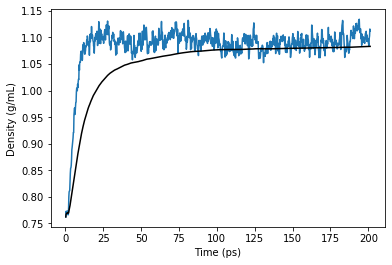

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = pd.read_csv(f'scalars_{solvent_box_name}_N{number_of_solvent_molecules}.csv')
time = data['#"Time (ps)"']
V = data["Box Volume (nm^3)"]
rho = data["Density (g/mL)"]
plt.plot(time,rho)
plt.xlabel('Time (ps)')
plt.ylabel('Density (g/mL)')

total_value = 0
ma_data=[]
for idx,value in enumerate(rho):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')

#http://ddbonline.ddbst.de/DIPPR105DensityCalculation/DIPPR105CalculationCGI.exe?component=Acetonitrile
#obtain via cid??? search tool?
print("The experimental saturated liquid density of acetonitril at 293.15K: 1.100 g/ml")
print(f"The average density at convergion is: {ma_data[-1]}")
print(f"The absolute difference between obtained and experimental density is (remark the T difference):{abs(ma_data[-1]-1.1)}")
plt.show()


##### Volume **V**

The average volume at convergion is: 12.010390359061246
The box dimensions for a NVT simulation should hence be: 22.90089071817561


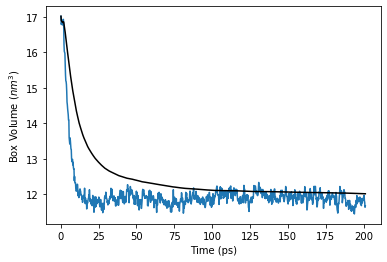

In [14]:
plt.plot(time,V)
plt.xlabel('Time (ps)')
plt.ylabel('Box Volume ($nm^3$)')
total_value = 0
ma_data=[]
for idx,value in enumerate(V):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')
print(f"The average volume at convergion is: {ma_data[-1]}")
cube_dim = ((ma_data[-1]**(1/3))*nanometer/angstrom)
print(f"The box dimensions for a NVT simulation should hence be: {cube_dim}")
plt.show()
plt.show()

### Creating a box with solvated solute(s)

####  Determining the number of solvent molecules (upper bound)

At the moment this volume is calculated with some manual input extracted a coordinate file manipulated with the program of choice. Ideally, in the future, this is automated. Here the calculated number of molecules is an upper bound as we do not account for the volume of the solutes itselves. This is easily done with Gaussian using the Volume keyword.

In [4]:
from molmod.units import *
from molmod.constants import *
import numpy as np

rho_exp = 1.1*gram/(centimeter**3)
MM= 78.14*gram #Molecular weight

##Determine initial box dimensions
#The number of solvent layers, can be determined using rdfs, or just use one in case only short range interactions are important and no proton-hopping mechanisms occur
number_of_solvent_layers = 1
Length_solutes =[6.3,5.5,5.0]
Length_solvent =[5.0]
Margin = [2.0] #this could be interesting to allow for through-space interactions occuring with the solvent which prevent close proximities
#2 options, on one hand you can allow for all solutes to be able to diffuse away from each other and get surrounded
# by a number of solvent layers (option 1); secondly one can make sure the total complex is surrounded with n solvent layers
# this latter option (option2) allows one to prevent far diffusion of the solutes and hence model reactivity?

option = 2

#If the solvent is a mixture one could calculate an alternative length? or take max length ?

Max_length = 0

if option==1:
    for length in Length_solutes:
        Max_length += number_of_solvent_layers*2*(Length_solvent[0]+Margin[0]) + length  
elif option==2:
    Max_length += number_of_solvent_layers*(Length_solvent[0]+Margin[0])*2 + sum(Length_solutes)

Total_length = np.sqrt((Max_length**2)/3)

Volume = (Total_length*angstrom)**3   #in bohr³
#Determine the number of solvent molecules
#1L ~= 1dm³ , approx
n_solvent_mol = int((rho_exp * Volume / MM) *avogadro)
print(f'The number of solvent molecules is:{n_solvent_mol}')



The number of solvent molecules is:47


#### Set box settings

In [5]:
#settings for solvent box
n_solvent_mol=60
sb_name = f'dbu_butanol_aCC_{len(solutes)}solutes_N{n_solvent_mol}solvent_box'


#number of molecules for each solute and solvent species in the order of the solutes and solvents provided before
n_molecules = [1,1,1,n_solvent_mol]
if len(n_molecules)!= len(solutes)+len(solvents): raise ValueError('Ascribe a number of molecules for each species') 

###  Using openmoltools (https://github.com/choderalab/openmoltools)

I have manually adjusted the packmol.py file (in ~/anaconda3/envs/openmm/lib/python3.7/site-packages/openmoltools) as the bonds were defined as an array of 1 x 4 
but in this case the bond type and order should be in the 3rd and fourth column, this is however not the case.
there for this is put to zero at the end which corresponds to a bond order and type of None, though antechambers
will put this correct normally based on the bonds. Alternatively n_atoms is added after each molecule 
to bonds_i [0] and [1] instead to avoid a potential loss of information.
'''
    #cast atom type and order to 0
    if len(bonds[0])==4:
        for idx,frame in enumerate(bonds):
               bonds[idx][2] = 0
               bonds[idx][3] = 0

TODO: Report to openmoltools

This is fixed in the new version, so it seems

In [7]:
from openmoltools import packmol
import mdtraj as md

pdb_filenames = [f"CID_{cid}.pdb" for cid in solutes+solvents]
print(pdb_filenames)
print(n_molecules)
smiles_codes = [Molecule.from_file(f"CID_{cid}.sdf").to_smiles() for cid in solutes+solvents]
if OpenEyeToolkitWrapper.is_available():
    print('Succesfuly using OpenEye')
    box_size = packmol.approximate_volume_by_density(smiles_codes,n_molecules,density=1.0)
else:
    box_size = Total_length


# create box with corresponding md_traj trajectory and topology
md_traj_trajectory = packmol.pack_box(pdb_filenames,n_molecules,box_size=box_size)
print(md_traj_trajectory.topology)
md_traj_trajectory.save_pdb(f'{sb_name}_openmoltools.pdb')


['CID_81184.pdb', 'CID_78175.pdb', 'CID_263.pdb', 'CID_679.pdb']
[1, 1, 1, 60]
Succesfuly using OpenEye

# Mixture

tolerance 2.000000
filetype pdb
output /tmp/tmpm7l5eqz1/tmpbbu1tvk7.pdb
add_amber_ter


structure CID_81184.pdb
  number 1
  inside box 0. 0. 0. 20.336960 20.336960 20.336960
end structure

structure CID_78175.pdb
  number 1
  inside box 0. 0. 0. 20.336960 20.336960 20.336960
end structure

structure CID_263.pdb
  number 1
  inside box 0. 0. 0. 20.336960 20.336960 20.336960
end structure

structure CID_679.pdb
  number 60
  inside box 0. 0. 0. 20.336960 20.336960 20.336960
end structure

<mdtraj.Topology with 63 chains, 63 residues, 659 atoms, 599 bonds>


### Visualize the created solvent box

In [8]:
import nglview
import ipywidgets

nglview.show_file(f"{sb_name}_openmoltools.pdb")

NGLWidget()

##  Generate a forcefield for the solvent box

In [13]:
#from simtk.openmm.app import *
#from simtk.openmm import *
#from simtk.unit import *


#Define all monomers (sdf,smiles or mol format) used in the solvent box, 
#(if a licence for openEye is obtained this can also be other formats are applicable)
monomer_names = [f"CID_{cid}.sdf" for cid in solutes+solvents]
pdb_box = PDBFile(f"{sb_name}_openmoltools.pdb")
unique_molecules = [Molecule.from_file(name) for name in monomer_names]

#omm_topology = pdb_box.getTopology()
box_positions = pdb_box.getPositions()
off_box_topology = Topology.from_openmm(pdb_box.topology, unique_molecules=unique_molecules)
#if Total_length/2*angstrom > 1*nanometer:
off_box_system = off_forcefield.create_openmm_system(off_box_topology)
#off_box_system.setNonbondedMethod(PME)
#else:
    #off_box_system.setCutoffDistance(Total_length/2*angstrom)
    #off_box_system = off_forcefield.create_openmm_system(off_box_topology,nonbondedMethod=PME,nonbondedCutoff=Total_length/2*angstrom)
    #off_box_system.setNonbondedMethod(PME)



## Performing an energy calculations

In [14]:
import numpy as np

integrator = VerletIntegrator(1.0 * femtoseconds)
context = Context(off_box_system, integrator)
context.setPositions(box_positions)
state = context.getState(getEnergy=True)
energy = state.getPotentialEnergy().in_units_of(kilojoules_per_mole)


print(f"Original energy: {energy}")

Original energy: 5899.141002052644 kJ/mol


## Performing a molecular dynamics simulations for the new compound

In [15]:
from sys import stdout
import time

#Thermostat
integrator = LangevinIntegrator(temperature*kelvin, 1/picosecond, timestep*femtoseconds)
#for isobaric simulation
off_box_system.addForce(MonteCarloBarostat(pressure*bar, temperature*kelvin))  

#setting up the simulation
simulation = Simulation(pdb_box.topology, off_box_system, integrator)
simulation.context.setPositions(box_positions)
simulation.minimizeEnergy()


with open(f"initial_{len(solutes)}solutes_N{n_solvent_mol}solvent_box.pdb", "w") as f:
    PDBFile.writeFile(simulation.topology, pdb_box.positions, f)
    
simulation.reporters = []
simulation.reporters.append(DCDReporter(f'traj_{len(solutes)}solutes_N{n_solvent_mol}solvent.dcd', 100))
simulation.reporters.append(StateDataReporter(stdout, 10000, step=True,
                                              temperature=True,volume=True, density=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter(f"scalars_{len(solutes)}solutes_N{n_solvent_mol}solvent.csv", 100, time=True,
                                              potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, density=True))

simulation.reporters.append(CheckpointReporter('checkpnt.chk', 50000))
print("Starting simulation")
start = time.process_time()

simulation.step(total_simulation_steps)

end = time.process_time()
print("Elapsed time %.2f seconds" % (end-start))
print("Done!")

simulation.saveCheckpoint('final_state.chk')
simulation.saveState('final_state_output.xml')


Starting simulation
#"Step","Temperature (K)","Box Volume (nm^3)","Density (g/mL)","Elapsed Time (s)"
10000,300.13412002880307,7.9751856744629075,1.0499225670799446,0.0001385211944580078
20000,264.936310558871,7.82459148568308,1.0701296587294373,15.926424026489258
30000,295.9958516876136,7.908376860528971,1.0587921597493555,30.516944646835327
40000,291.13348828597475,7.522328189169763,1.1131297659050234,45.00574851036072
50000,291.873671384124,7.654779465129785,1.0938691904077382,59.55178642272949
60000,305.41215210692195,7.876210487094438,1.0631162574935509,74.21947836875916
70000,307.62849438959717,7.4741416509053344,1.12030622476322,88.70563125610352
80000,293.5439084100682,7.629375675706039,1.0975114835325512,103.20205760002136
90000,289.9734310272289,7.806272051346714,1.072640994471459,117.67552185058594
100000,279.60319415044387,7.786628099033949,1.0753470320882714,132.20008206367493
110000,310.4968451772376,7.761042283296255,1.0788921269367175,146.83002495765686
120000,304.80031

In [16]:
simulation.saveCheckpoint('final_state.chk')
simulation.saveState('final_state_output.xml')

## Visualize the output

In [17]:
traj = md.load(f'traj_{len(solutes)}solutes_N{n_solvent_mol}solvent.dcd', top=f"initial_{len(solutes)}solutes_N{n_solvent_mol}solvent_box.pdb")
traj.superpose(traj, 0)
nglview.show_mdtraj(traj)

NGLWidget(count=5000)

## Post-Processing

The average density at convergion is: 1.083223429084866


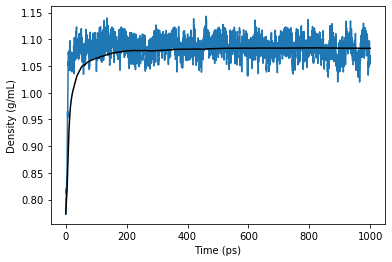

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv(f"scalars_{len(solutes)}solutes_N{n_solvent_mol}solvent.csv")
#print(data.head())
time = data['#"Time (ps)"']
V = data["Box Volume (nm^3)"]
rho = data["Density (g/mL)"]
plt.plot(time,rho)
plt.xlabel('Time (ps)')
plt.ylabel('Density (g/mL)')

total_value = 0
ma_data=[]
for idx,value in enumerate(rho):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')

#http://ddbonline.ddbst.de/DIPPR105DensityCalculation/DIPPR105CalculationCGI.exe?component=Acetonitrile
print(f"The average density at convergion is: {ma_data[-1]}")

plt.show()

The average volume at convergion is: 7.735283664871107
The box dimensions for a NVT simulation should hence be: 19.77692416335168


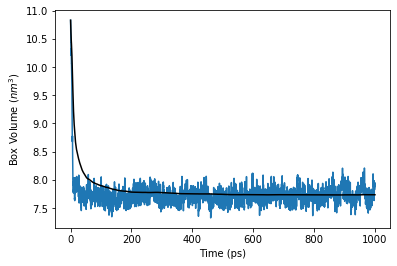

In [19]:
plt.plot(time,V)
plt.xlabel('Time (ps)')
plt.ylabel('Box Volume ($nm^3$)')
total_value = 0
ma_data=[]
for idx,value in enumerate(V):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')
print(f"The average volume at convergion is: {ma_data[-1]}")
#cube dimension in Angstrom
cube_dim = ((ma_data[-1]**(1/3))*nanometer/angstrom)
print(f"The box dimensions for a NVT simulation should hence be: {cube_dim}")
plt.show()

In [ ]:
from sys import stdout
import time
simulation.reporters.append(CheckpointReporter('checkpnt.chk', 50000))
print("Starting simulation")
start = time.process_time()

simulation.step(total_simulation_steps*2)
end = time.process_time()
print("Elapsed time %.2f seconds" % (end-start))
print("Done!")

simulation.saveCheckpoint('final_state.chk')
simulation.saveState('final_state_output.xml')


The average density at convergion is: 1.0897773794534986


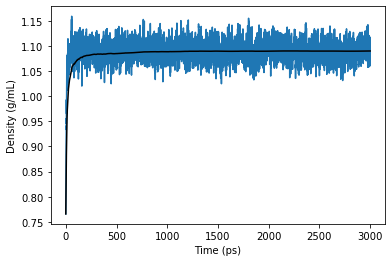

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv(f"scalars_{len(solutes)}solutes_N{n_solvent_mol}solvent.csv")
#print(data.head())
time = data['#"Time (ps)"']
V = data["Box Volume (nm^3)"]
rho = data["Density (g/mL)"]
plt.plot(time,rho)
plt.xlabel('Time (ps)')
plt.ylabel('Density (g/mL)')

total_value = 0
ma_data=[]
for idx,value in enumerate(rho):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')

#http://ddbonline.ddbst.de/DIPPR105DensityCalculation/DIPPR105CalculationCGI.exe?component=Acetonitrile
print(f"The average density at convergion is: {ma_data[-1]}")

plt.show()

The average volume at convergion is: 7.738289654034322
The box dimensions for a NVT simulation should hence be: 19.779485651856827


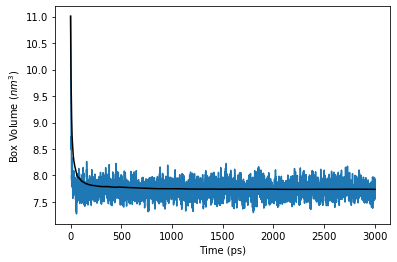

In [45]:
plt.plot(time,V)
plt.xlabel('Time (ps)')
plt.ylabel('Box Volume ($nm^3$)')
total_value = 0
ma_data=[]
for idx,value in enumerate(V):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')
print(f"The average volume at convergion is: {ma_data[-1]}")
#cube dimension in Angstrom
cube_dim = ((ma_data[-1]**(1/3))*nanometer/angstrom)
print(f"The box dimensions for a NVT simulation should hence be: {cube_dim}")
plt.show()